<a href="https://colab.research.google.com/github/thaygorh/predicao-de-taxa/blob/main/predicao_fluxo_motor_vfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: *Machine Learning & Analytics* - Predi√ß√£o de Fluxo de Massa a partir da Corrente de um Motor
**Autor:** Thaygor Henrique Gon√ßalves  

**Data:** 28/09/2025

**Matr√≠cula:** 4052025000871

**Dataset:**  [Motor Current Dataset](https://raw.githubusercontent.com/thaygorh/predicao-de-taxa/refs/heads/main/MVP_MLA_dados_tratados2.csv)

---

## ‚úÖ Checklist do MVP (o que precisa conter)
- [X] **Problema definido e contexto de neg√≥cio** ‚Üí Checklist respondido, defini√ß√£o clara do problema, hip√≥teses e dataset.  
- [X] **Tratamento dos dados** ‚Üí Pr√©-processamento, normaliza√ß√£o e tratamento.  
- [X] **Carga e prepara√ß√£o dos dados** ‚Üí Ordena√ß√£o temporal, configura√ß√£o de features e target.  
- [X] **Divis√£o em treino/valida√ß√£o/teste** ‚Üí 90% treino+val / 10% teste holdout.  
- [X] **Modelagem (com baseline)** ‚Üí Compara√ß√£o entre DummyRegressor, Ridge, RandomForest, GradientBoosting, LightGBM, CatBoost.  
- [X] **Otimiza√ß√£o de hiperpar√¢metros** ‚Üí GridSearchCV com TimeSeriesSplit.  
- [X] **Salvando artefatos** ‚Üí Salvar e recarregar o melhor modelo, sem precisar retreinar.  
- [X] **Boas pr√°ticas** ‚Üí Seeds fixadas, tempo de treino, documenta√ß√£o em Markdown explicativa, uso de Pipeline.  
- [X] **Avalia√ß√£o e discuss√£o de limita√ß√µes** ‚Üí Holdout (MAE, RMSE, R¬≤), compara√ß√£o com baseline, curvas de resposta, fun√ß√µes saturantes e h√≠brida.  
- [X] **Conclus√£o** ‚Üí S√≠ntese dos resultados, melhores modelos, limita√ß√µes e poss√≠veis aplica√ß√µes pr√°ticas.  

---

## 1. Escopo, objetivo e defini√ß√£o do problema

**Contexto do problema e objetivo:**  
Este trabalho tem como objetivo avaliar a viabilidade da predi√ß√£o da taxa de material (t/h) a partir da corrente el√©trica de um motor (A). Em muitos ambientes industriais a instala√ß√£o de balan√ßas pode ser invi√°vel devido a custo, manuten√ß√£o ou restri√ß√µes f√≠sicas. Dessa forma, busca-se verificar se a corrente pode ser utilizada como alternativa para essa predi√ß√£o, al√©m de identificar qual modelo de aprendizado supervisionado apresenta o melhor desempenho.

**Tipo de tarefa**  
Problema de regress√£o supervisionada, j√° que a vari√°vel-alvo √© cont√≠nua (taxa em t/h).  

**Hip√≥tese**  
Existe rela√ß√£o monot√¥nica crescente, mas n√£o linear, entre a corrente do motor e o fluxo de massa, permitindo estimar a vaz√£o.

**√Årea de aplica√ß√£o**  
Dados tabulares obtidos de sensores industriais.  

**Valor para o neg√≥cio/usu√°rio:**  
A solu√ß√£o proposta possibilita reduzir custos com instala√ß√£o e manuten√ß√£o de balan√ßas, al√©m de ampliar a disponibilidade de estimativas de taxa em locais onde n√£o √© poss√≠vel realizar a medi√ß√£o direta.

---

## 2. Reprodutibilidade e ambiente

A fim de garantir a reprodutibilidade, o ambiente foi configurado com as seguintes caracter√≠sticas:

- **Bibliotecas:** NumPy, Pandas, Matplotlib, SciPy, Scikit-learn, LightGBM, CatBoost, Joblib e Requests.  
- **Seed global:** Definida como "42".  
- **Aplica√ß√£o da seed:** Utilizada nos geradores do NumPy e do Python random para manter consist√™ncia.



### 2.1 Depend√™ncias

Apenas as bibliotecas adicionais que n√£o fazem parte do ambiente padr√£o do Google Colab.

In [16]:
!pip install -q lightgbm catboost

### 2.2 Importa√ß√µes e configura√ß√£o do ambiente

Foram importadas as bibliotecas necess√°rias para manipula√ß√£o de dados, visualiza√ß√£o, modelagem estat√≠stica e machine learning. Tamb√©m foram inclu√≠dos pacotes utilit√°rios para salvar modelos e realizar requisi√ß√µes externas.  

In [17]:
# 2.2 Bibliotecas e Configura√ß√µes Iniciais

# Configura√ß√£o para n√£o exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Utilidades gerais
import os, sys, math, random, time, joblib, requests

# Manipula√ß√£o de dados
import numpy as np
import pandas as pd

# Visualiza√ß√£o
import matplotlib.pyplot as plt

# Modelagem estat√≠stica / matem√°tica
from scipy.optimize import curve_fit

# Machine Learning - Scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Boosting avan√ßado
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Seed global para reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


### 2.3 Fun√ß√µes Python

Fun√ß√µes auxiliares foram criadas para organizar o c√≥digo:

- **`make_folds`** ‚Üí gera √≠ndices de treino e valida√ß√£o respeitando a ordem cronol√≥gica. Importante em s√©ries temporais, pois preserva a sequ√™ncia temporal e evita o vazamento de dados.
- **`sat_with_threshold`** ‚Üí implementa uma rela√ß√£o saturante com limiar fixo (œÑ), representando o ponto em que o motor come√ßa efetivamente a transportar material.  
- **`sat_with_exponent`** ‚Üí vers√£o mais flex√≠vel da fun√ß√£o anterior, onde o expoente *p* ajusta a curvatura da resposta. Essa generaliza√ß√£o permite capturar com maior fidelidade a din√¢mica n√£o linear entre corrente e fluxo de massa.  



In [18]:
def make_folds(X, y, n_folds=5):
    """
    Gera √≠ndices de treino e valida√ß√£o para valida√ß√£o cruzada em s√©ries temporais.

    Par√¢metros:
    - X : pd.DataFrame ou np.ndarray
        Features.
    - y : pd.Series ou np.ndarray
        Target correspondente.
    - n_folds : int, opcional (default=5)
        N√∫mero de blocos de valida√ß√£o.

    Retorna:
    - folds : list of tuples
        Lista de tuplas (train_idx, test_idx).
    """
    block_size = len(X) // n_folds
    folds = []
    for i in range(n_folds):
        start = i * block_size
        end = (i + 1) * block_size
        test_idx = list(range(start, end))
        train_idx = list(range(0, start)) + list(range(end, len(X)))
        folds.append((train_idx, test_idx))
    return folds


def sat_with_threshold(x, A, k, tau_fixed):
    """
    Fun√ß√£o saturante com limiar (œÑ) fixo.

    Prop√≥sito:
    Modelar a rela√ß√£o n√£o linear entre corrente do motor e fluxo de massa,
    representando o comportamento em que abaixo de certo limiar (œÑ) n√£o h√°
    transporte de material, e acima desse valor a taxa cresce de forma
    assint√≥tica at√© se estabilizar.

    F√≥rmula:
    y(x) = 0, se x ‚â§ œÑ
    y(x) = A * (1 - exp(-k * (x - œÑ))), se x > œÑ

    Par√¢metros:
    - x : array-like, entradas (corrente do motor em A)
    - A : float, valor assint√≥tico (taxa m√°xima estimada)
    - k : float, taxa de crescimento exponencial
    - tau_fixed : float, limiar fixo (œÑ)

    Retorna:
    - y : array-like, valores previstos
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    mask = x > tau_fixed
    y[mask] = A * (1.0 - np.exp(-k * (x[mask] - tau_fixed)))
    return y


def sat_with_exponent(x, A, k, p, tau_fixed):
    """
    Fun√ß√£o saturante com limiar (œÑ) fixo e expoente livre.

    Prop√≥sito:
    Generalizar a fun√ß√£o saturante para ajustar melhor a curvatura da rela√ß√£o
    entre corrente e taxa, permitindo mais flexibilidade no ajuste.

    F√≥rmula:
    y(x) = 0, se x ‚â§ œÑ
    y(x) = A * (1 - exp(-k * (x - œÑ)^p)), se x > œÑ

    Par√¢metros:
    - x : array-like, entradas (corrente do motor em A)
    - A : float, valor assint√≥tico (taxa m√°xima estimada)
    - k : float, taxa de crescimento exponencial
    - p : float, expoente de curvatura
    - tau_fixed : float, limiar fixo (œÑ)

    Retorna:
    - y : array-like, valores previstos
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    mask = x > tau_fixed
    y[mask] = A * (1.0 - np.exp(-k * np.power(x[mask] - tau_fixed, p)))
    return y


## 3. Dados: carga, entendimento e qualidade  

- **Origem dos dados:** fornecidos por uma empresa parceira para fins de estudo.  
- **Aspectos √©ticos e confidencialidade:** n√£o s√£o detalhados aspectos espec√≠ficos do processo (como tipo de motor ou aplica√ß√£o direta dos equipamentos), garantindo sigilo das informa√ß√µes.  
- **Dicion√°rio de vari√°veis:**  
  - **Corrente do Motor (A):** corrente el√©trica em amperes, utilizada como vari√°vel explicativa.  
  - **Taxa da Balan√ßa (t/h):** fluxo de material medido por uma balan√ßa instalada ap√≥s o motor, em toneladas por hora, definida como vari√°vel-alvo.  
- **Qualidade e pr√©-processamento:** o dataset foi disponibilizado j√° tratado, o que reduz o risco de ru√≠dos na modelagem.  
  - O valor da balan√ßa foi previamente defasado em planilha (Excel), devido a maior praticidade na identifica√ß√£o do deslocamento temporal correto.  
  - N√£o h√° valores nulos.
  - Foi feita a padroniza√ß√£o num√©rica (v√≠rgula ‚Üí ponto) e a uniformiza√ß√£o dos nomes das colunas em `snake_case`.



In [19]:
# Carga e verifica√ß√£o inicial dos dados

# Carregar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/thaygorh/predicao-de-taxa/refs/heads/main/MVP_MLA_dados_tratados2.csv",
    sep=";"
)

# Converter v√≠rgula decimal para ponto em colunas num√©ricas
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = df[col].astype(str).str.replace(",", ".", regex=False).astype(float)
        except ValueError:
            pass

# Renomear colunas para snake_case
df = df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"))

# Resetar √≠ndice
df = df.reset_index(drop=True)

# Exibir amostras e informa√ß√µes b√°sicas
display(df.head())
print("\nFormato:", df.shape)
print("\nTipos de dados:\n", df.dtypes)
print("\nValores ausentes por coluna:\n", df.isna().sum())


corrente_do_motor  taxa_da_balanca
0               27.5              0.0
1               27.5              0.0
2               27.5              0.0
3               27.5              0.0
4               27.5              0.0


Formato: (12928, 2)

Tipos de dados:
 corrente_do_motor    float64
taxa_da_balanca      float64
dtype: object

Valores ausentes por coluna:
 corrente_do_motor    0
taxa_da_balanca      0
dtype: int64


### 3.1 An√°lise explorat√≥ria resumida (EDA)

Nesta etapa foi realizada uma an√°lise explorat√≥ria inicial para compreender o comportamento das vari√°veis ao longo do tempo.

Observa√ß√µes preliminares:
- As vari√°veis **corrente_do_motor** e **taxa_da_balanca** apresentam comportamento correlacionado, indicando que a corrente pode ser usada como preditora da taxa.  
- Aumentos na corrente tendem a acompanhar aumentos no fluxo de material registrado pela balan√ßa.
- Valores de corrente pr√≥ximos ao m√≠nimo observado parecem estar associados ao motor ligado sem passagem de material (taxa pr√≥xima de zero).

O gr√°fico de s√©ries temporais permite visualizar essa rela√ß√£o de forma clara, evidenciando padr√µes √∫teis para a etapa de modelagem.


corrente_do_motor  taxa_da_balanca
count       12928.000000     12928.000000
mean           46.957658      6096.124172
std            17.222962      4164.591804
min             0.000000         0.000000
25%            28.775000      1681.522250
50%            50.500000      7773.470000
75%            60.500000      9759.527000
max           102.400000     12617.270000

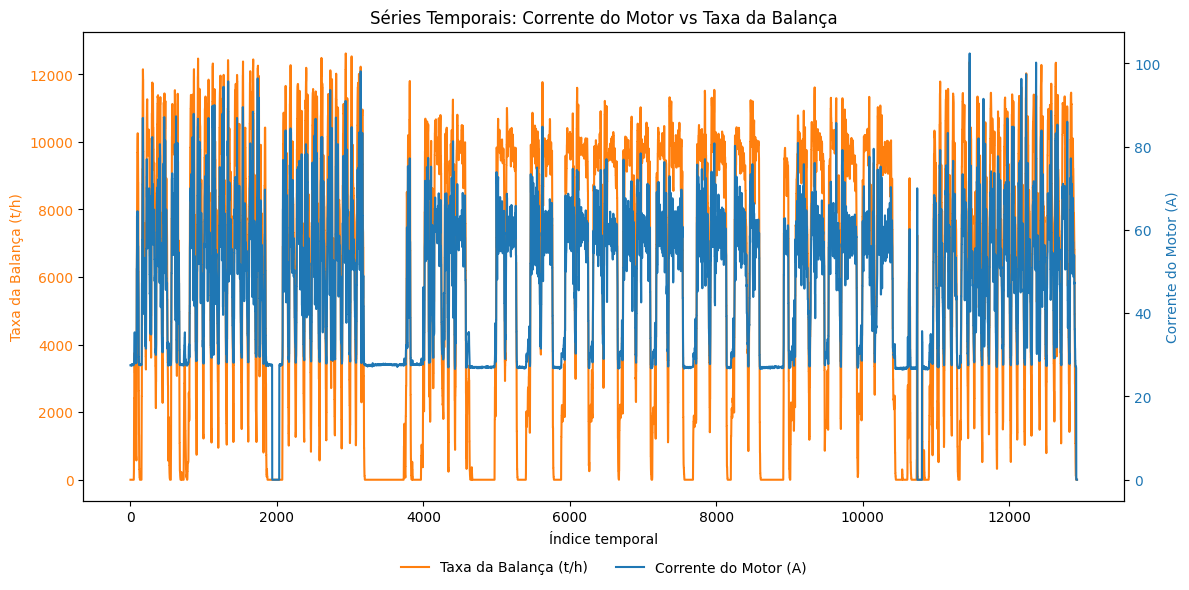

In [20]:
# Estat√≠sticas descritivas
display(df.describe())

# S√©ries temporais: taxa (eixo principal) e corrente (eixo secund√°rio)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df.index, df['taxa_da_balanca'], color='tab:orange', label='Taxa da Balan√ßa (t/h)')
ax1.set_xlabel('√çndice temporal')
ax1.set_ylabel('Taxa da Balan√ßa (t/h)', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

ax2 = ax1.twinx()
ax2.plot(df.index, df['corrente_do_motor'], color='tab:blue', label='Corrente do Motor (A)')
ax2.set_ylabel('Corrente do Motor (A)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax1.set_title('S√©ries Temporais: Corrente do Motor vs Taxa da Balan√ßa')

# Legenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)

plt.tight_layout()
plt.show()


## 4. Defini√ß√£o do target, vari√°veis e divis√£o dos dados

- **Target (vari√°vel-alvo):** `taxa_da_balanca` (t/h).  
- **Vari√°vel preditora:** `corrente_do_motor` (A).  

- **Divis√£o dos dados:**  
  - Os primeiros **90% das amostras** s√£o usados para treino e valida√ß√£o, aplicando **valida√ß√£o cruzada** temporal em 5 blocos de tamanho igual.  
  - Os √∫ltimos **10% das amostras** formam o conjunto **holdout**, reservado exclusivamente para a avalia√ß√£o final.  

- **Observa√ß√£o:** Como se trata de **s√©rie temporal**, a divis√£o respeita a ordem cronol√≥gica, prevenindo vazamento de informa√ß√£o. O conjunto holdout garante uma avalia√ß√£o imparcial, simulando um cen√°rio de predi√ß√£o em dados futuros n√£o vistos durante o treino.  


In [21]:
# Defini√ß√£o do problema e divis√£o dos dados

PROBLEM_TYPE = "regressao"

# Target e feature
target = "taxa_da_balanca"
feature_cols = ["corrente_do_motor"]

X_all = df[feature_cols].copy()
y_all = df[target].copy()

# Separa√ß√£o em treino/valida√ß√£o (CV) e holdout final
holdout_size = int(len(X_all) * 0.1)  # √∫ltimos 10% dos dados
split_point = len(X_all) - holdout_size

X_cv, y_cv = X_all.iloc[:split_point], y_all.iloc[:split_point]
X_holdout, y_holdout = X_all.iloc[split_point:], y_all.iloc[split_point:]

# Criar folds usando fun√ß√£o definida no t√≥pico 2.3
folds = make_folds(X_cv, y_cv, n_folds=5)

# Resumo
print(f"PROBLEM_TYPE: {PROBLEM_TYPE}")
print(f"Target: {target}")
print(f"N features: {X_all.shape[1]}")
print(f"Treino + Valida√ß√£o (Cross-Validation): {X_cv.shape}")
print(f"Holdout final: {X_holdout.shape}\n")

print("Valida√ß√£o cruzada temporal (5 folds):")
for i, (train_idx, test_idx) in enumerate(folds, 1):
    print(f" - Fold {i}: Valida√ß√£o = amostras {test_idx[0]}‚Äì{test_idx[-1]} | Treino = restante")

PROBLEM_TYPE: regressao
Target: taxa_da_balanca
N features: 1
Treino + Valida√ß√£o (Cross-Validation): (11636, 1)
Holdout final: (1292, 1)

Valida√ß√£o cruzada temporal (5 folds):
 - Fold 1: Valida√ß√£o = amostras 0‚Äì2326 | Treino = restante
 - Fold 2: Valida√ß√£o = amostras 2327‚Äì4653 | Treino = restante
 - Fold 3: Valida√ß√£o = amostras 4654‚Äì6980 | Treino = restante
 - Fold 4: Valida√ß√£o = amostras 6981‚Äì9307 | Treino = restante
 - Fold 5: Valida√ß√£o = amostras 9308‚Äì11634 | Treino = restante


## 5. Tratamento de dados e pipeline de pr√©-processamento  

Foram definidos dois pr√©-processadores para avaliar o impacto da normaliza√ß√£o no desempenho dos modelos:

- **Raw (sem normaliza√ß√£o):** utiliza os dados brutos diretamente.  
- **Scaled (com normaliza√ß√£o):** aplica `StandardScaler` sobre a vari√°vel preditora.  

Essa abordagem permite comparar se a padroniza√ß√£o traz ganhos relevantes para o ajuste dos modelos, especialmente em algoritmos sens√≠veis √† escala dos dados (como regress√£o linear e m√©todos baseados em gradiente). Al√©m disso, garante que o scaler seja ajustado apenas nos dados de treino.




In [22]:
# Tratamento de dados e pr√©-processamento

# Pr√©-processamento sem normaliza√ß√£o (dados brutos)
preprocess_raw = ColumnTransformer(
    transformers=[("pass", "passthrough", feature_cols)],
    remainder="drop"
)

# Pr√©-processamento com normaliza√ß√£o (StandardScaler)
preprocess_scaled = ColumnTransformer(
    transformers=[("scale", StandardScaler(), feature_cols)],
    remainder="drop"
)

print("Pr√©-processadores definidos:")
print(" - Raw (sem normaliza√ß√£o)")
print(" - Scaled (com StandardScaler)")


Pr√©-processadores definidos:
 - Raw (sem normaliza√ß√£o)
 - Scaled (com StandardScaler)


## 6. Baseline e modelos candidatos  

Foi utilizado um **DummyRegressor** como baseline, que prev√™ sempre a m√©dia dos valores de treino. Esse baseline define o limite inferior de desempenho: os modelos precisam super√°-lo para demonstrar que de fato capturam padr√µes nos dados, e n√£o apenas reproduzem estimativas.

Modelos selecionados para compara√ß√£o:  
- **Ridge Regression** ‚Üí regress√£o linear com regulariza√ß√£o L2: verificar se uma abordagem linear consegue capturar parte da rela√ß√£o entre corrente e taxa.  
- **Random Forest Regressor** ‚Üí conjunto de √°rvores de decis√£o: robusto para capturar n√£o linearidades sem necessidade de grande pr√©-processamento.  
- **Gradient Boosting Regressor** ‚Üí boosting sequencial de √°rvores: tende a ajustar melhor padr√µes complexos.  
- **SGD Regressor** ‚Üí regress√£o linear otimizada por descida de gradiente: eficiente em bases maiores, mas menos robusto em problemas n√£o lineares, servindo como comparativo com Ridge.  
- **LightGBM** ‚Üí variante otimizada de gradient boosting: projetada para velocidade e escalabilidade.  
- **CatBoost** ‚Üí algoritmo de boosting eficiente para dados tabulares: conhecido por bom desempenho consistente e simplicidade de uso.  

Cada modelo foi avaliado em duas vers√µes:  
- **Raw** (dados sem normaliza√ß√£o)  
- **Scaled** (dados normalizados com `StandardScaler`)  

A diversidade de modelos permite comparar solu√ß√µes lineares simples at√© algoritmos mais sofisticados de ensemble.  


In [23]:
# Baseline e modelos candidatos

# Fun√ß√£o de avalia√ß√£o
def eval_reg(y_true, y_pred, label=''):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return dict(Modelo=label, MAE=mae, RMSE=rmse, R2=r2)

# Fun√ß√£o para grid search
def run_grid(pipe, params, Xtr, ytr):
    t0 = time.time()
    gs = GridSearchCV(
        pipe, params,
        scoring='neg_mean_absolute_error',
        cv=3, n_jobs=-1, verbose=0
    )
    gs.fit(Xtr, ytr)
    elapsed = time.time() - t0
    return gs, elapsed

# Defini√ß√£o dos modelos candidatos
models = {
    "Baseline": None,

    "Ridge": (Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('reg', Ridge())
    ]), {
        'poly__degree': [1, 2],
        'reg__alpha': [0.1, 1.0, 10.0]
    }),

    "RandomForest": (Pipeline([
        ('rf', RandomForestRegressor(random_state=SEED))
    ]), {
        'rf__n_estimators': [200, 400],
        'rf__max_depth': [None, 15, 25]
    }),

    "GradientBoosting": (Pipeline([
        ('gb', GradientBoostingRegressor(random_state=SEED))
    ]), {
        'gb__n_estimators': [200, 400],
        'gb__learning_rate': [0.05, 0.1]
    }),

    "SGDRegressor": (Pipeline([
        ('sgd', SGDRegressor(random_state=SEED, max_iter=1000))
    ]), {
        'sgd__alpha': [0.0001, 0.001],
        'sgd__penalty': ['l2', 'l1']
    }),

    "LightGBM": (Pipeline([
        ('lgbm', LGBMRegressor(
            random_state=SEED,
            verbosity=-1   # logs: -1 (sem logs), 0 (erros), 1 (info), >1 (debug detalhado)
        ))
    ]), {
        'lgbm__n_estimators': [200, 400],
        'lgbm__learning_rate': [0.05, 0.1],
        'lgbm__max_depth': [-1, 15, 25]
    }),

    "CatBoost": (Pipeline([
        ('cat', CatBoostRegressor(
            random_state=SEED,
            verbose=0   # logs: 0 (sem sa√≠da), >0 imprime a cada N itera√ß√µes
        ))
    ]), {
        'cat__iterations': [200, 400],
        'cat__learning_rate': [0.05, 0.1],
        'cat__depth': [6, 10]
    })
}


## 7. Valida√ß√£o, Otimiza√ß√£o e Resultados  

Os modelos foram treinados e avaliados com **valida√ß√£o cruzada temporal (5 folds)**.
O ajuste de hiperpar√¢metros foi feito com **GridSearchCV** em cada fold, garantindo que o processo de treino fosse sistem√°tico e compar√°vel.  

#### M√©tricas utilizadas  
- **MAE (Mean Absolute Error):** erro absoluto m√©dio.  
- **RMSE (Root Mean Squared Error):** erro quadr√°tico m√©dio, mais sens√≠vel a outliers.  
- **R¬≤ (Coeficiente de Determina√ß√£o):** propor√ß√£o da vari√¢ncia explicada pelo modelo.  

Para cada modelo, foram calculadas as m√©tricas em cada fold.  
Os resultados exibidos correspondem √† **m√©dia dos 5 folds**, acompanhados do **desvio-padr√£o (¬± std)**.  

#### Interpreta√ß√£o  
- A **m√©dia** mostra o desempenho esperado do modelo.  
- O **desvio-padr√£o** indica a estabilidade:  
  - Valores baixos ‚Üí desempenho consistente entre os folds.  
  - Valores altos ‚Üí menor confiabilidade, devido √† maior varia√ß√£o de desempenho entre os folds.   

O **Baseline (DummyRegressor)** n√£o realiza treinamento, por isso o tempo de treino aparece como `NaN`.  
Todas as m√©tricas do baseline foram muito ruins em compara√ß√£o com os outros modelos, confirmando que a simples m√©dia dos valores de treino n√£o seria aplic√°vel em um caso real.  

#### Observa√ß√£o sobre o processo  
Para evitar repetir todo o processo de treino sempre que o notebook for executado, foi inclu√≠da a op√ß√£o de **force_retrain**.  
Por padr√£o, a vari√°vel `force_retrain` est√° como `False`, mas pode ser alterada para `True` caso seja necess√°rio treinar novamente.  


In [24]:
# 7. Valida√ß√£o, Otimiza√ß√£o e Resultados (com salvamento no GitHub)

force_retrain = False  # Coloque True se quiser rodar novamente todo o treino + valida√ß√£o cruzada
model_url = "https://raw.githubusercontent.com/thaygorh/predicao-de-taxa/main/best_model.pkl"
model_path = "best_model.pkl"

if not force_retrain:
    try:
        if not os.path.exists(model_path):
            print("Baixando best_model.pkl do GitHub...")
            r = requests.get(model_url)
            open(model_path, "wb").write(r.content)
        df_cv_mean, best_model = joblib.load(model_path)
        print("Melhor modelo carregado do arquivo salvo!")
    except Exception as e:
        print("Falha ao carregar do GitHub, treinando novamente...", e)
        force_retrain = True

if force_retrain:
    print("Treinando todos os modelos e executando a valida√ß√£o cruzada completa...")

    results = []

    # Loop para Raw e Scaled
    for prep_name, prep in [("Raw", preprocess_raw), ("Scaled", preprocess_scaled)]:
        for name, cfg in models.items():

            if name == "Baseline":
                for i, (train_idx, test_idx) in enumerate(folds, 1):
                    y_train = y_cv.iloc[train_idx]
                    y_test  = y_cv.iloc[test_idx]
                    y_pred  = np.full_like(y_test.values, y_train.mean(), dtype=float)
                    results.append(eval_reg(y_test, y_pred, label=f"{name}_{prep_name}_Fold{i}"))
            else:
                pipe, grid = cfg
                steps = [('prep', prep)] + pipe.steps
                pipe = Pipeline(steps)

                for i, (train_idx, test_idx) in enumerate(folds, 1):
                    X_train, y_train = X_cv.iloc[train_idx], y_cv.iloc[train_idx]
                    X_test,  y_test  = X_cv.iloc[test_idx],  y_cv.iloc[test_idx]

                    gs, dt = run_grid(pipe, grid, X_train, y_train)
                    y_pred = gs.predict(X_test)

                    rec = eval_reg(y_test, y_pred, label=f"{name}_{prep_name}_Fold{i}")
                    rec["TrainTime_s"] = dt
                    results.append(rec)

    df_results = pd.DataFrame(results)
    df_results["Modelo_Base"] = df_results["Modelo"].str.replace(r"_Fold\d+","", regex=True)

    # Estat√≠sticas: m√©dia e desvio-padr√£o das m√©tricas, soma do tempo
    df_cv_mean = (
        df_results
        .groupby("Modelo_Base")
        .agg({
            "MAE": ["mean", "std"],
            "RMSE": ["mean", "std"],
            "R2": ["mean", "std"],
            "TrainTime_s": "sum"
        })
        .reset_index()
    )

    # Renomear colunas para clareza
    df_cv_mean.columns = [
        'Modelo_Base',
        'MAE_mean', 'MAE_std',
        'RMSE_mean', 'RMSE_std',
        'R2_mean', 'R2_std',
        'TrainTime_total'
    ]

    # Ordenar pelo melhor R¬≤ m√©dio
    df_cv_mean = df_cv_mean.sort_values(by="R2_mean", ascending=False)

    best_model = df_cv_mean.iloc[0]
    print(f"\n Melhor desempenho m√©dio: {best_model['Modelo_Base']} (R¬≤ = {best_model['R2_mean']:.4f} ¬± {best_model['R2_std']:.4f})\n")

    # üîπ Salva apenas os resultados da valida√ß√£o cruzada
    joblib.dump((df_cv_mean, best_model), model_path)

df_cv_mean


Melhor modelo carregado do arquivo salvo!


Modelo_Base     MAE_mean     MAE_std    RMSE_mean    RMSE_std  \
3           CatBoost_Scaled   551.158718  136.503769   782.349106  169.108716   
2              CatBoost_Raw   551.158718  136.503769   782.349106  169.108716   
4      GradientBoosting_Raw   554.374053  134.198591   787.111115  169.214542   
5   GradientBoosting_Scaled   554.369239  134.179239   787.122863  169.218925   
6              LightGBM_Raw   560.474873  131.879974   793.697565  166.873416   
7           LightGBM_Scaled   560.741800  130.579102   796.359093  166.085784   
8          RandomForest_Raw   593.652642  139.664632   845.506454  177.857921   
9       RandomForest_Scaled   594.320728  139.284392   846.030982  177.181407   
13      SGDRegressor_Scaled  1214.373346  161.983108  1509.751410  288.110721   
10                Ridge_Raw  1116.015236  143.367158  1525.574753  427.602760   
11             Ridge_Scaled  1116.019116  143.359313  1525.588898  427.589107   
12         SGDRegressor_Raw  1539.818448  478.773373  1881.833183  559.001333   
0              Baseline_Raw  3934.639410  167.771759  4246.487655  162.667838   
1           Baseline_Scaled  3934.639410  167.771759  4246.487655  162.667838   

     R2_mean    R2_std  TrainTime_total  
3   0.963870  0.015961       150.134499  
2   0.963870  0.015961       146.244869  
4   0.963446  0.016148        49.618305  
5   0.963445  0.016147        48.704693  
6   0.962895  0.016111        45.791175  
7   0.962656  0.016129        42.225844  
8   0.957870  0.018470       138.900531  
9   0.957831  0.018421       128.504548  
13  0.866372  0.057691         1.079861  
10  0.857962  0.087550         8.125463  
11  0.857960  0.087547         1.833080  
12  0.786337  0.126169         2.231334  
0  -0.015764  0.025116         0.000000  
1  -0.015764  0.025116         0.000000

## 8. Avalia√ß√£o final no Holdout, an√°lise de erros e limita√ß√µes  

O melhor modelo, selecionado na valida√ß√£o cruzada, foi o **CatBoost_Raw**.  
Ele foi re-treinado em **todo o conjunto de treino/valida√ß√£o (90% dos dados)** e avaliado no **holdout (10%)**, que permaneceu totalmente separado durante o processo.  

Esse conjunto funciona como um **teste final real**, representando um cen√°rio mais pr√≥ximo da aplica√ß√£o em produ√ß√£o e permitindo avaliar a capacidade de generaliza√ß√£o em dados nunca vistos.  

As m√©tricas finais consideradas foram: **MAE, RMSE e R¬≤**.  

#### Observa√ß√µes  
- A compara√ß√£o com o **DummyRegressor (baseline)** evidencia o ganho real do modelo sobre uma estrat√©gia ing√™nua.  
- O uso do holdout garante avalia√ß√£o imparcial. Apesar do R¬≤ no holdout ter sido de **0.89**, ligeiramente abaixo do valor observado em treino/valida√ß√£o (**0.96**), o resultado ainda √© considerado muito satisfat√≥rio.
- Limita√ß√µes: quantidade de dados dispon√≠vel, depend√™ncia temporal e a necessidade de uma balan√ßa calibrada para garantir que a vari√°vel alvo esteja correta e o modelo seja confi√°vel.

In [25]:
# 8. Avalia√ß√£o final no Holdout (com salvamento no GitHub)

force_retrain = False  # Coloque True se quiser treinar novamente
model_url = "https://raw.githubusercontent.com/thaygorh/predicao-de-taxa/main/best_model_final.pkl"
model_path = "best_model_final.pkl"

if not force_retrain:
    try:
        if not os.path.exists(model_path):
            print("Baixando best_model_final.pkl do GitHub...")
            r = requests.get(model_url)
            open(model_path, "wb").write(r.content)
        gs = joblib.load(model_path)
        print("Modelo final carregado com sucesso!")
    except Exception as e:
        print("Falha ao carregar do GitHub, treinando novamente...", e)
        force_retrain = True

if force_retrain:
    print("Treinando novamente o melhor modelo no conjunto treino/valida√ß√£o...")

    best_model_name = best_model["Modelo_Base"]  # <- corrigido

    # Identificar se Raw ou Scaled
    prep_type = "Raw" if "Raw" in best_model_name else "Scaled"
    prep = preprocess_raw if prep_type == "Raw" else preprocess_scaled

    # Nome base do modelo
    base_name = best_model_name.replace("_Raw", "").replace("_Scaled", "")
    pipe, grid = models[base_name]

    steps = [('prep', prep)] + pipe.steps
    pipe = Pipeline(steps)

    # Treinar com todo o treino+valida√ß√£o
    gs = GridSearchCV(pipe, grid, scoring='r2', cv=3, n_jobs=-1, verbose=0)
    gs.fit(X_cv, y_cv)

    # üîπ Salva o modelo final treinado
    joblib.dump(gs, model_path)
    print(f"Novo modelo salvo em {model_path}")

# Avalia√ß√£o no Holdout
y_pred_holdout = gs.predict(X_holdout)
rec_best = eval_reg(y_holdout, y_pred_holdout, label=f"{best_model_name}_Holdout")

# Baseline no Holdout
y_pred_baseline = np.full_like(y_holdout.values, y_cv.mean(), dtype=float)
rec_base = eval_reg(y_holdout, y_pred_baseline, label="Baseline_Holdout")

# DataFrame comparando Baseline vs Melhor Modelo
df_holdout = (
    pd.DataFrame([rec_base, rec_best])
    .round(4)
    .rename(columns={
        "Modelo": "Modelo",
        "MAE": "MAE_holdout",
        "RMSE": "RMSE_holdout",
        "R2": "R2_holdout"
    })
)

display(df_holdout)


Modelo final carregado com sucesso!


Modelo  MAE_holdout  RMSE_holdout  R2_holdout
0         Baseline_Holdout    3092.1737     3481.2449     -0.2432
1  CatBoost_Scaled_Holdout     776.3925     1012.9003      0.8948

### 8.1 Visualiza√ß√£o das previs√µes no Holdout  

Para complementar a an√°lise num√©rica, foi gerada uma visualiza√ß√£o das s√©ries temporais no conjunto **holdout**.  
O gr√°fico compara diretamente:  

- **Taxa da Balan√ßa real (t/h)** ‚Äî valores efetivamente medidos.  
- **Predi√ß√£o da Taxa (t/h)** ‚Äî valores estimados pelo modelo selecionado (**CatBoost_Raw**).  
- **Corrente do Motor (A)** ‚Äî exibida no eixo secund√°rio apenas como refer√™ncia contextual.  

#### Interpreta√ß√£o  
De modo geral, o modelo reproduz de forma consistente o comportamento da taxa de material.
As principais diferen√ßas aparecem em pontos de mudan√ßa brusca ou picos curtos, onde a resposta prevista tende a ser suavizada em rela√ß√£o ao valor real.
Ainda assim, o alinhamento entre as curvas indica que o modelo capturou bem a rela√ß√£o entre corrente e fluxo de material.



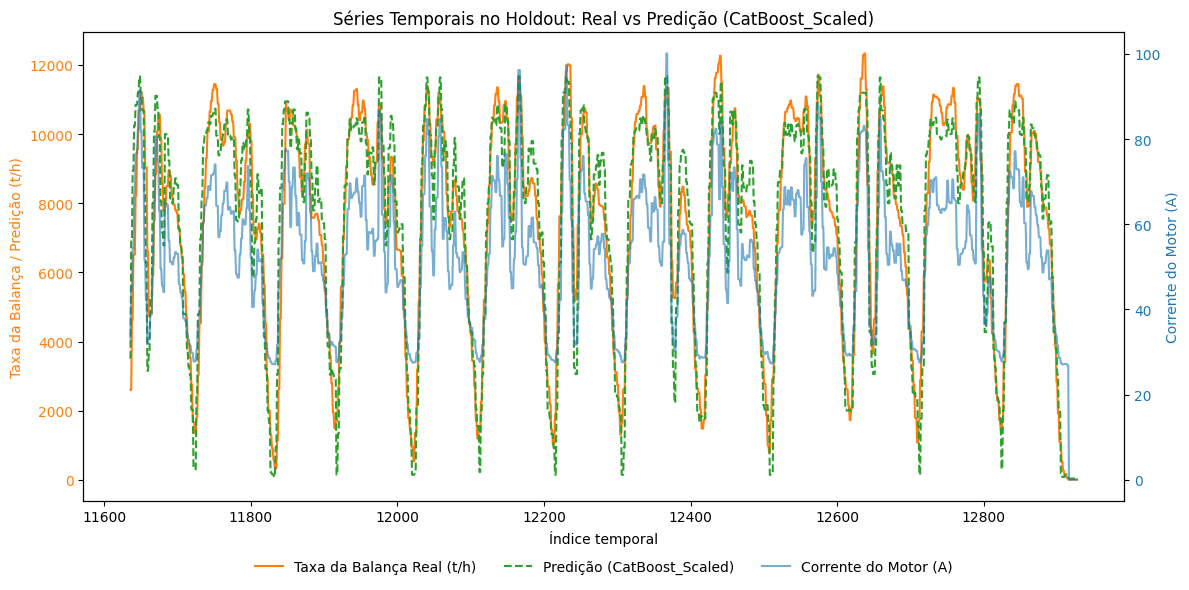

In [26]:
# 8.1 Visualiza√ß√£o das previs√µes (Holdout)

plt.figure(figsize=(12, 6))
ax1 = plt.gca()

# Taxa da Balan√ßa real
ax1.plot(y_holdout.index, y_holdout.values, color='tab:orange', label='Taxa da Balan√ßa Real (t/h)')

# Predi√ß√£o do modelo selecionado
ax1.plot(
    y_holdout.index, y_pred_holdout,
    color='tab:green', linestyle='--',
    label=f'Predi√ß√£o ({best_model["Modelo_Base"]})'
)

ax1.set_xlabel('√çndice temporal')
ax1.set_ylabel('Taxa da Balan√ßa / Predi√ß√£o (t/h)', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# Corrente do Motor no eixo secund√°rio (refer√™ncia)
ax2 = ax1.twinx()
ax2.plot(X_holdout.index, X_holdout['corrente_do_motor'], color='tab:blue', alpha=0.6, label='Corrente do Motor (A)')
ax2.set_ylabel('Corrente do Motor (A)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# T√≠tulo e legenda
plt.title(f'S√©ries Temporais no Holdout: Real vs Predi√ß√£o ({best_model["Modelo_Base"]})')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(
    lines_1 + lines_2, labels_1 + labels_2,
    loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False
)

plt.tight_layout()
plt.show()


### 8.2 Curva de resposta do modelo  

Para analisar o comportamento do modelo selecionado, foi simulada uma s√©rie de correntes variando de **0,0 a 100,0 A** em passos de **0,1 A**.  

O modelo previu a **Taxa da Balan√ßa (t/h)** para cada valor dessa faixa, resultando em uma **curva de resposta** que mostra como ele aprendeu a relacionar a corrente do motor com a taxa prevista.  

#### Interpreta√ß√£o  
At√© aproximadamente **83 A**, a curva acompanha bem a rela√ß√£o esperada, indicando que havia dados consistentes nessa faixa para o treinamento.  
Acima desse valor, a curva tende a se estabilizar quase em uma constante, reflexo da escassez de observa√ß√µes nessa regi√£o e possivelmente tamb√©m do limite operacional do motor.  
As previs√µes feitas a partir dessa faixa devem ser vistas com cautela.  

Essa an√°lise ser√° utilizada no t√≥pico seguinte ao criar uma **fun√ß√£o matem√°tica** como forma alternativa de representa√ß√£o, permitindo avaliar se essa aproxima√ß√£o consegue capturar o mesmo comportamento observado no modelo treinado.


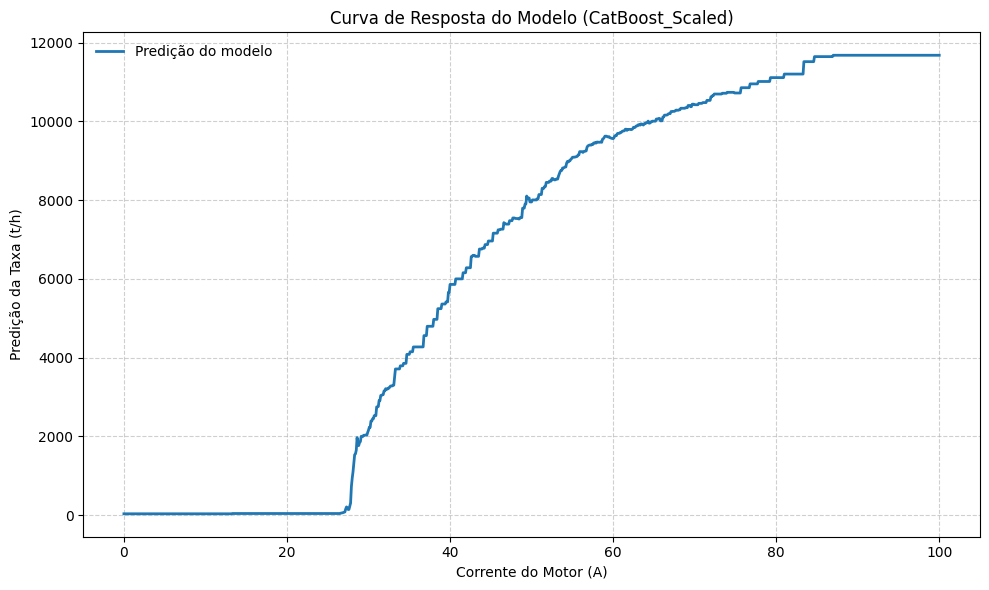

In [27]:
# 8.2 Curva de resposta do modelo

# Gera√ß√£o de correntes simuladas (0 a 100 A, passo 0.1)
corrente_simulada = np.arange(0, 100.1, 0.1)
X_simulado = pd.DataFrame(corrente_simulada, columns=["corrente_do_motor"])

# Predi√ß√£o do modelo treinado (pipeline gs j√° inclui pr√©-processador)
y_pred_simulada = gs.predict(X_simulado)

# Gr√°fico da curva de resposta
plt.figure(figsize=(10, 6))
plt.plot(
    X_simulado["corrente_do_motor"], y_pred_simulada,
    linewidth=2, label="Predi√ß√£o do modelo"
)

plt.xlabel("Corrente do Motor (A)")
plt.ylabel("Predi√ß√£o da Taxa (t/h)")
plt.title(f"Curva de Resposta do Modelo ({best_model_name})")
plt.legend(frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### 8.3 Ajuste de fun√ß√£o saturante - Global  

A partir da curva de resposta (T√≥pico 8.2), foi realizado o ajuste de uma **fun√ß√£o saturante** (`sat_with_exponent` no c√≥digo) para avaliar se a rela√ß√£o entre corrente e taxa pode ser representada de forma mais simples.  

A ideia √© que abaixo de um certo **limiar f√≠sico (œÑ)** n√£o h√° taxa de material sendo movimentada, e acima dele a taxa cresce rapidamente at√© se estabilizar. Essa formula√ß√£o tem coer√™ncia f√≠sica com o funcionamento do motor e fornece uma representa√ß√£o anal√≠tica alternativa e de f√°cil interpreta√ß√£o.  

#### Etapas  
1. Foi considerada a faixa de **0 a 100 A**.  
2. Definiu-se um **limiar fixo (œÑ = 27.5 A)** com base no ponto de subida do gr√°fico.  
3. Os par√¢metros **A** (valor assint√≥tico m√°ximo), **k** (taxa de crescimento) e **p** (expoente de curvatura) foram ajustados automaticamente com `curve_fit`, garantindo que n√£o fossem definidos de forma arbitr√°ria, mas extra√≠dos das pr√≥prias predi√ß√µes do modelo (**CatBoost_Raw**).  
4. A fun√ß√£o ajustada foi ent√£o comparada com as predi√ß√µes do modelo para verificar se mant√©m uma forma coerente e interpret√°vel.  

#### F√≥rmula matem√°tica  

- y(x) = 0, se x ‚â§ œÑ  
- y(x) = A * (1 - exp(-k * (x - œÑ)^p)), se x > œÑ

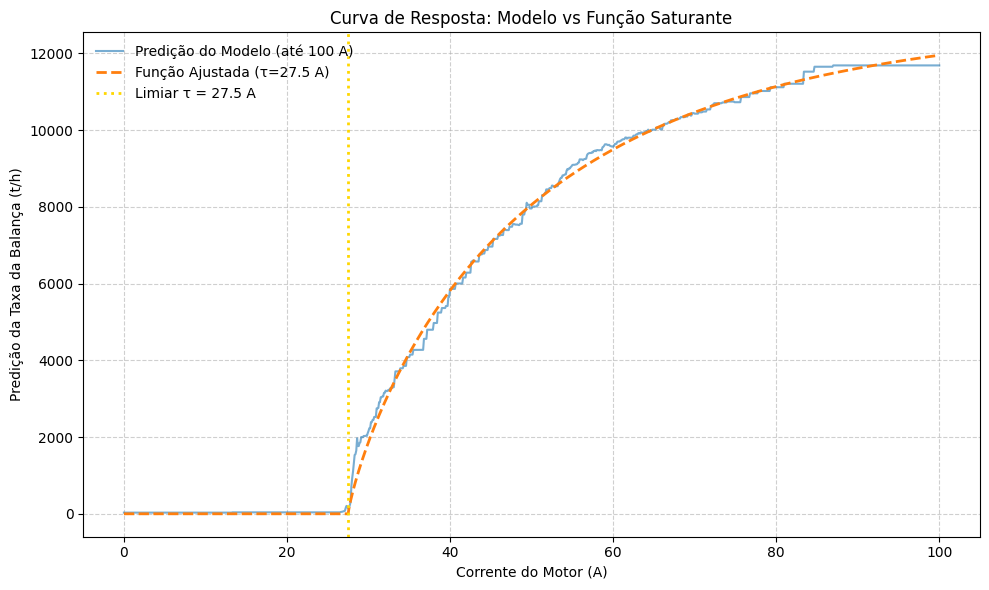

Fun√ß√£o ajustada (x em A, y em t/h):
y(x) = 0, se x ‚â§ 27.5
y(x) = 12911.90 * (1 - exp(-0.0729 * (x - 27.5)^0.83)), se x > 27.5


In [28]:
# 8.3 Ajuste de fun√ß√£o saturante (com limiar fixo e expoente livre)

# 1) Simula√ß√£o at√© 100 A
x = np.arange(0, 100.1, 0.1)
X_sim = pd.DataFrame({"corrente_do_motor": x})
y_model = gs.predict(X_sim)

# 2) Defini√ß√£o do limiar œÑ
tau = 27.5  # limiar f√≠sico (A)

# 3) Ajuste dos par√¢metros A, k e p usando curve_fit
mask_fit = x > tau
x_fit, y_fit = x[mask_fit], y_model[mask_fit]

# Chutes iniciais
A0 = np.nanpercentile(y_fit, 95) if len(y_fit) else 8000.0
k0, p0 = 0.05, 0.8

popt, _ = curve_fit(
    lambda xv, A, k, p: sat_with_exponent(xv, A, k, p, tau),
    x_fit, y_fit, p0=[A0, k0, p0],
    bounds=([0, 0, 0.1], [np.inf, np.inf, 2.0]),
    maxfev=20000
)
A_hat, k_hat, p_hat = popt

# 4) Predi√ß√£o da fun√ß√£o ajustada
y_fun = sat_with_exponent(x, A_hat, k_hat, p_hat, tau)

# 5) Compara√ß√£o gr√°fica
plt.figure(figsize=(10, 6))
plt.plot(x, y_model, alpha=0.6, label="Predi√ß√£o do Modelo (at√© 100 A)")
plt.plot(x, y_fun, linestyle="--", linewidth=2,
         label=f"Fun√ß√£o Ajustada (œÑ={tau:.1f} A)")
plt.axvline(tau, color="gold", linestyle=":", linewidth=2,
            label=f"Limiar œÑ = {tau:.1f} A")

plt.xlabel("Corrente do Motor (A)")
plt.ylabel("Predi√ß√£o da Taxa da Balan√ßa (t/h)")
plt.title("Curva de Resposta: Modelo vs Fun√ß√£o Saturante")

# Legenda no canto superior esquerdo
plt.legend(loc="upper left", frameon=False)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 6) Exibir f√≥rmula final
print("Fun√ß√£o ajustada (x em A, y em t/h):")
print(f"y(x) = 0, se x ‚â§ {tau:.1f}")
print(f"y(x) = {A_hat:.2f} * (1 - exp(-{k_hat:.4f} * (x - {tau:.1f})^{p_hat:.2f})), se x > {tau:.1f}")


### 8.4 Fun√ß√£o saturante - Local  

No T√≥pico 8.3 foi ajustada a curva global at√© **100 A**, mas a **subida inicial (27.5 A a 29.9 A)** n√£o foi representada com precis√£o.  

Para capturar melhor esse comportamento inicial, foi ajustada uma fun√ß√£o saturante restrita a esse intervalo, permitindo representar de forma mais fiel a **curva de crescimento inicial**.  

#### Etapas  
1. Considerada a faixa de **0 a 29.9 A**, isolando a regi√£o de interesse.  
2. Definido o **limiar fixo (œÑ = 27.5 A)**, pr√≥ximo ao ponto em que o motor inicia o transporte efetivo.  
3. Os par√¢metros **A** (valor assint√≥tico m√°ximo), **k** (taxa de crescimento) e **p** (expoente de curvatura) foram ajustados automaticamente com `curve_fit`, garantindo que n√£o fossem arbitr√°rios, mas fundamentados nas predi√ß√µes do modelo (**CatBoost_Raw**).  
4. A fun√ß√£o ajustada foi comparada √†s predi√ß√µes do modelo apenas nesse intervalo, verificando sua ader√™ncia ao comportamento inicial.  

#### Interpreta√ß√£o  
Esse ajuste captura de forma mais precisa a **primeira curva de subida**, sendo um passo importante para a cria√ß√£o de uma **fun√ß√£o h√≠brida** que combine o comportamento inicial (at√© 29.9 A) com a curva global (at√© 100 A).  


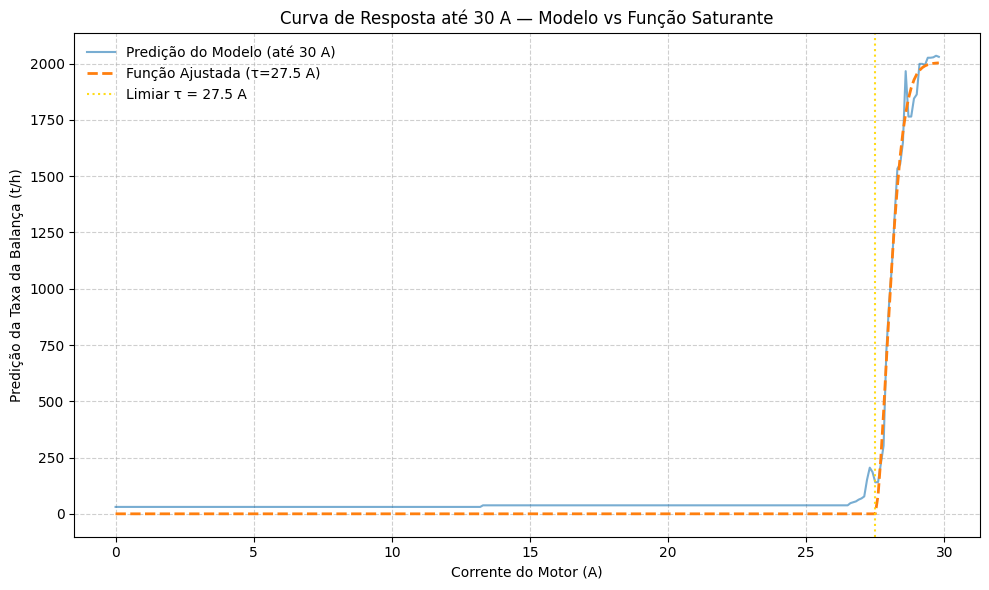

Fun√ß√£o ajustada (x em A, y em t/h):
y(x) = 0, se x ‚â§ 27.5
y(x) = 2004.52 * (1 - exp(-1.8704 * (x - 27.5)^1.65)), se x > 27.5


In [29]:
# 8.4 Fun√ß√£o saturante Local

# 1) Simula√ß√£o at√© 30 A
x = np.arange(0, 29.9, 0.1)
X_sim = pd.DataFrame({"corrente_do_motor": x})
y_model = gs.predict(X_sim)

# 2) Defini√ß√£o do limiar œÑ
tau = 27.5  # limiar f√≠sico (em A)

# 3) Ajuste dos par√¢metros A, k e p usando a fun√ß√£o auxiliar sat_with_exponent (definida no t√≥pico 2.3)
mask_fit = x > tau
x_fit = x[mask_fit]
y_fit = y_model[mask_fit]

# Chutes iniciais
A0 = np.nanpercentile(y_fit, 95) if len(y_fit) else 8000.0
k0, p0 = 0.05, 0.8

# Ajuste com restri√ß√µes
popt, _ = curve_fit(
    lambda xv, A, k, p: sat_with_exponent(xv, A, k, p, tau),
    x_fit, y_fit, p0=[A0, k0, p0],
    bounds=([0, 0, 0.1], [np.inf, np.inf, 2.0]),
    maxfev=20000
)
A_hat, k_hat, p_hat = popt

# 4) Predi√ß√£o da fun√ß√£o ajustada
y_fun = sat_with_exponent(x, A_hat, k_hat, p_hat, tau)

# 5) Compara√ß√£o gr√°fica
plt.figure(figsize=(10, 6))
plt.plot(x, y_model, alpha=0.6, label="Predi√ß√£o do Modelo (at√© 30 A)")
plt.plot(x, y_fun, linestyle="--", linewidth=2,
         label=f"Fun√ß√£o Ajustada (œÑ={tau:.1f} A)")
plt.axvline(tau, color="gold", linestyle=":", alpha=0.9,
            label=f"Limiar œÑ = {tau:.1f} A")

plt.xlabel("Corrente do Motor (A)")
plt.ylabel("Predi√ß√£o da Taxa da Balan√ßa (t/h)")
plt.title("Curva de Resposta at√© 30 A ‚Äî Modelo vs Fun√ß√£o Saturante")

# Legenda no canto superior esquerdo para evitar sobreposi√ß√£o
plt.legend(loc="upper left", frameon=False)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 6) Exibir f√≥rmula final
print("Fun√ß√£o ajustada (x em A, y em t/h):")
print(f"y(x) = 0, se x ‚â§ {tau:.1f}")
print(f"y(x) = {A_hat:.2f} * (1 - exp(-{k_hat:.4f} * (x - {tau:.1f})^{p_hat:.2f})), se x > {tau:.1f}")


### 8.5 Curva H√≠brida: Local (at√© 29.9 A) + Global (at√© 100 A)  

Nos t√≥picos anteriores, vimos que:  
- A curva ajustada pela fun√ß√£o global n√£o representava bem a **subida inicial** (27.5 A a 29.9 A).  
- O ajuste local capturou melhor esse comportamento inicial, mas n√£o era adequado para toda a faixa.  

Diante disso, foi criada uma **curva h√≠brida**, que combina os dois ajustes:  
- **Ajuste Local (27.5 A at√© 29.9 A):** descreve com maior precis√£o o in√≠cio da curva ap√≥s o limiar.  
- **Ajuste Global (30 A at√© 100 A):** aplicado somente ap√≥s o t√©rmino do ajuste local, representando a tend√™ncia geral e a satura√ß√£o em correntes maiores.  

Essa curva h√≠brida **n√£o foi definida arbitrariamente**: ela foi constru√≠da a partir das **predi√ß√µes do modelo selecionado (CatBoost_Raw)**, servindo como uma representa√ß√£o funcional aproximada da rela√ß√£o aprendida.  

#### Interpreta√ß√£o  
A fun√ß√£o h√≠brida proporciona uma **maior clareza na interpreta√ß√£o**, ao unir as duas curvas em uma formula√ß√£o bem definida:  
- Uma **subida inicial mais √≠ngreme** (capturada pelo ajuste local).  
- Uma **tend√™ncia de satura√ß√£o gradual** (capturada pelo ajuste global).  

O gr√°fico mostra que a curva h√≠brida ficou muito pr√≥xima da predi√ß√£o feita pelo modelo.

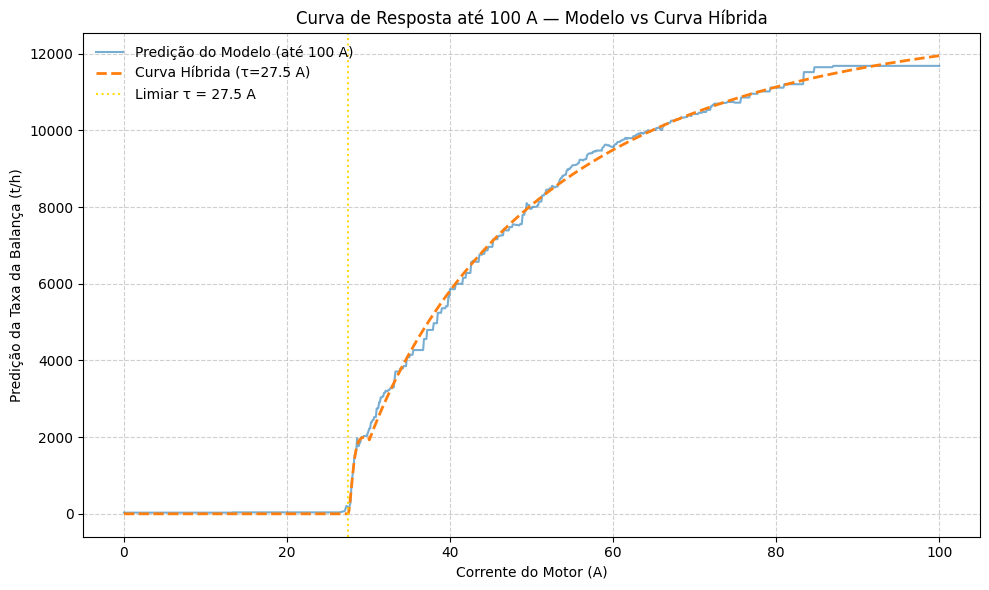

Fun√ß√£o H√≠brida Ajustada (x em A, y em t/h):
y(x) = 0, se x ‚â§ 27.5
y(x) = 2004.52 * (1 - exp(-1.8704 * (x - 27.5)^1.65)), se 27.5 < x ‚â§ 30
y(x) = 12911.90 * (1 - exp(-0.0729 * (x - 27.5)^0.83)), se x > 30


In [30]:
# 8.5 Curva H√≠brida: Local (at√© 29.9 A) + Global (at√© 100 A)

# 1) Simula√ß√£o do intervalo de interesse
x = np.arange(0, 100.1, 0.1)
X_sim = pd.DataFrame({"corrente_do_motor": x})
y_model = gs.predict(X_sim)  # valores previstos pelo melhor modelo

# 2) Defini√ß√£o do limiar f√≠sico
tau = 27.5  # corrente a partir da qual h√° transporte efetivo

# 3) Ajuste LOCAL (27.8 A at√© 29.9 A)
mask_fit_loc = (x > tau) & (x <= 29.9)
x_fit_loc, y_fit_loc = x[mask_fit_loc], y_model[mask_fit_loc]

popt_loc, _ = curve_fit(
    lambda xv, A, k, p: sat_with_exponent(xv, A, k, p, tau),
    x_fit_loc, y_fit_loc,
    p0=[2000, 1.0, 2.0],
    bounds=([0, 0, 0.1], [np.inf, np.inf, 3.0]),
    maxfev=20000
)
A_loc, k_loc, p_loc = popt_loc

# 4) Ajuste GLOBAL (27.8 A at√© 100 A)
mask_fit_glob = x > tau
x_fit_glob, y_fit_glob = x[mask_fit_glob], y_model[mask_fit_glob]

popt_glob, _ = curve_fit(
    lambda xv, A, k, p: sat_with_exponent(xv, A, k, p, tau),
    x_fit_glob, y_fit_glob,
    p0=[13000, 0.05, 1.0],
    bounds=([0, 0, 0.1], [np.inf, np.inf, 2.0]),
    maxfev=20000
)
A_glob, k_glob, p_glob = popt_glob

# 5) Constru√ß√£o da curva h√≠brida
y_hybrid = np.zeros_like(x, dtype=float)
mask_local = (x > tau) & (x <= 30)
mask_global = x > 30

y_hybrid[mask_local] = sat_with_exponent(x[mask_local], A_loc, k_loc, p_loc, tau)
y_hybrid[mask_global] = sat_with_exponent(x[mask_global], A_glob, k_glob, p_glob, tau)

# 6) Compara√ß√£o gr√°fica
plt.figure(figsize=(10, 6))
plt.plot(x, y_model, alpha=0.6, label="Predi√ß√£o do Modelo (at√© 100 A)", color="tab:blue")
plt.plot(x, y_hybrid, linestyle="--", linewidth=2, color="tab:orange",
         label=f"Curva H√≠brida (œÑ={tau:.1f} A)")
plt.axvline(tau, color="gold", linestyle=":", alpha=0.9, label=f"Limiar œÑ = {tau:.1f} A")

plt.xlabel("Corrente do Motor (A)")
plt.ylabel("Predi√ß√£o da Taxa da Balan√ßa (t/h)")
plt.title("Curva de Resposta at√© 100 A ‚Äî Modelo vs Curva H√≠brida")

# Legenda no canto superior esquerdo
plt.legend(loc="upper left", frameon=False)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 7) F√≥rmula final da fun√ß√£o h√≠brida
print("Fun√ß√£o H√≠brida Ajustada (x em A, y em t/h):")
print(f"y(x) = 0, se x ‚â§ {tau:.1f}")
print(f"y(x) = {A_loc:.2f} * (1 - exp(-{k_loc:.4f} * (x - {tau:.1f})^{p_loc:.2f})), se {tau:.1f} < x ‚â§ 30")
print(f"y(x) = {A_glob:.2f} * (1 - exp(-{k_glob:.4f} * (x - {tau:.1f})^{p_glob:.2f})), se x > 30")

### 8.6 Valida√ß√£o pr√°tica em Excel  

Para verificar a aplicabilidade da fun√ß√£o h√≠brida fora do ambiente Python, os par√¢metros ajustados foram utilizados para gerar um gr√°fico no **Excel**.  

#### Fun√ß√£o Saturante H√≠brida  
y(x) = 0, se x ‚â§ 27.5  
y(x) = 2004.52 * (1 - exp(-1.8704 * (x - 27.5)^1.65)), se 27.5 < x ‚â§ 30  
y(x) = 12911.90 * (1 - exp(-0.0729 * (x - 27.5)^0.83)), se x > 30  

- No gr√°fico, a curva h√≠brida foi identificada na legenda como:  
**Fun√ß√£o Saturante H√≠brida (y = A¬∑(1 - exp(-k¬∑(x-œÑ)^p)))**  

![image.png](attachment:image.png)  

#### Observa√ß√µes  
- A fun√ß√£o foi aplicada diretamente sobre os dados reais de **corrente do motor** e comparada com os valores medidos pela **balan√ßa**.  
- O resultado refor√ßa que o modelo aprendeu de maneira consistente a rela√ß√£o entre as vari√°veis.  
- A fun√ß√£o deve ser ajustada sempre que novos treinamentos forem realizados.  


## 9. Conclus√£o  

O objetivo deste trabalho foi validar a viabilidade de realizar a **predi√ß√£o do fluxo de massa a partir da corrente de um motor**, utilizando os dados de uma balan√ßa como refer√™ncia para valida√ß√£o. Para isso, foram testados diferentes modelos de regress√£o, desde o **DummyRegressor (baseline)** at√© algoritmos de machine learning mais sofisticados.  

O modelo **CatBoost** apresentou o melhor desempenho, alcan√ßando resultados consistentes nas m√©tricas avaliadas (**MAE, RMSE e R¬≤**) e com **baixo desvio-padr√£o**, indicando estabilidade e aus√™ncia de ind√≠cios de underfitting ou overfitting em rela√ß√£o ao baseline.  
Na valida√ß√£o cruzada, o **CatBoost_Raw** atingiu **R¬≤ m√©dio de 0.9639 ¬± 0.0159**, mostrando um bom desempenho e consist√™ncia entre os folds.  

#### Observa√ß√µes  
- Outros modelos, como **Gradient Boosting** e **LightGBM**, tamb√©m apresentaram bom desempenho, embora com resultados ligeiramente inferiores.  
- Apesar dos bons resultados, ainda existem limita√ß√µes, como a defasagem temporal, que n√£o √© fixa, entre a corrente do motor e a leitura da balan√ßa e a rela√ß√£o entre o tamanho do dataset e o tempo de treinamento.  
- Futuramente, uma base de dados maior pode contribuir para melhorar a robustez da estimativa, al√©m de refinar a fun√ß√£o saturante constru√≠da a partir das predi√ß√µes dos modelos.  
- Dessa forma, surgem duas possibilidades de aplica√ß√£o:  
  1. Utilizar diretamente o modelo com melhor resultado para estimar o fluxo de massa a partir da corrente.  
  2. Adotar a fun√ß√£o h√≠brida derivada das predi√ß√µes do modelo, que mostrou ader√™ncia √† din√¢mica f√≠sica do motor. Essa alternativa pode trazer vantagens pr√°ticas, pois o uso de uma fun√ß√£o matem√°tica em vez do carregamento do modelo completo pode tornar o c√≥digo mais leve e eficiente.  

De forma geral, o estudo demonstrou que √© vi√°vel prever a taxa de material (t/h) a partir da corrente el√©trica do motor analisado, e que a abordagem pode ser estendida para outros sensores industriais.